In [1]:
from icecube import icetray, dataio, dataclasses, simclasses, phys_services, recclasses
import os, sys
import numpy as np
import matplotlib as mpl
from matplotlib.colors import LogNorm, Normalize
import matplotlib.pyplot as plt
import timeit as time
import math
from datetime import datetime
import timeit

In [2]:

files_dir = '/data/icecube/domeff_analysis/reco_sim_nominal/0000000-0000999'
# List the contents of the entire directory
file_list_aux = os.listdir(files_dir)
# Only keep those that are I3 files
file_list = [x for x in file_list_aux if '.i3.bz2' in x]
print('Total files', len(file_list))

Total files 966


In [3]:
sys.path.append('/data/icecube/domeff_analysis/reco_sim_nominal/0000000-0000999')

In [4]:
import Functions_for_detector


Total files 966


In [5]:
import Corrected_function

Total files 966


In [6]:
#import Double

Total files 966


In [7]:
nfiles = 1

frame_arr = []; mctree = []
volume_radius = 500. # In meters
volume_top    = 500. # In meters
counter_single = 0
counter_multi_reject = 0

In [8]:
single = Functions_for_detector.counters(volume_radius, volume_top, counter_single, counter_multi_reject)[0]
multi = Functions_for_detector.counters(volume_radius, volume_top, counter_single, counter_multi_reject)[1]
muon_index = Functions_for_detector.counters(volume_radius, volume_top, counter_single, counter_multi_reject)[2]

In [9]:
#mu = []
#for i in range(len(muon_index)):
#    if muon_index[i] < 0 : continue
#    mu.append(muon_index[i])
#mu = np.array(mu)
#print(len(mu))

In [10]:
stoch = Functions_for_detector.stochastic_losses(single, multi, volume_radius, volume_top, muon_index)

In [11]:
from icecube.weighting import fluxes
#fluxes.GaisserH3a
flux_to_use = fluxes.GaisserH4a()

In [12]:
def getCorsikaWeight(corsika_weight_map, myflux):
    corsika_weight_map = frame['CorsikaWeightMap']
    pflux = myflux(corsika_weight_map['PrimaryEnergy'], corsika_weight_map['PrimaryType'])
    energy_integral = (corsika_weight_map['EnergyPrimaryMax']**(corsika_weight_map["PrimarySpectralIndex"]+1)-
                   corsika_weight_map['EnergyPrimaryMin']**(corsika_weight_map["PrimarySpectralIndex"]+1))/(
    corsika_weight_map["PrimarySpectralIndex"]+1)
    energy_weight = corsika_weight_map['PrimaryEnergy']**corsika_weight_map["PrimarySpectralIndex"]
    w = pflux *energy_integral/energy_weight * corsika_weight_map["AreaSum"] / (corsika_weight_map['NEvents'])
    return w

In [13]:
frame_arr = []; mctree = []
stoch_ar = []

total_ar = []
std_ar =[]

events = []


for i in range(nfiles):
    with dataio.I3File(os.path.join(files_dir,file_list[i])) as infile:
        for frame in infile:
            if infile.stream.id != 'P': continue 
            frame_arr.append(frame)
            mctree.append(frame['I3MCTree'])
            cwm = frame['CorsikaWeightMap']
            event_weight = getCorsikaWeight(cwm, flux_to_use)
            events.append(event_weight)
            

In [14]:
Q = Corrected_function.func(frame,frame_arr, counter_single,counter_multi_reject,  volume_radius, volume_top, muon_index)[0]

In [15]:
print(len(Q))
print(len(muon_index))
print(len(events))
print(len(stoch))

1403
1403
1403
1403


In [23]:
Corrected = []
Weight = []
Stoch = []
for i, frame in enumerate(frame_arr):
    if muon_index[i] < 0: continue
    Corrected.append(Q[i])
    Weight.append(events[i])
    Stoch.append(stoch[i])
print(len(Stoch))
print(len(Corrected))
print(len(Weight))

1024
1024
1024


In [43]:
#between first and last doms
distance = Corrected_function.func(frame,frame_arr, counter_single,counter_multi_reject,  volume_radius, volume_top, muon_index)[1]

In [44]:
print(distance) #distance between the first and last DOMs

551.4178535638952


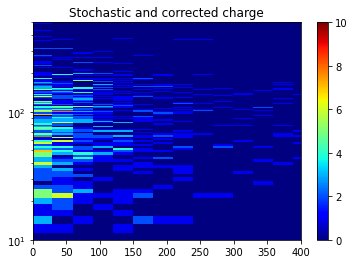

In [40]:
plt.yscale('log')
plt.hist2d(Stoch, Corrected , bins=(250, 250), cmap=plt.cm.jet)
plt.colorbar()
plt.xlim(0,400)
plt.ylim(10,500)

plt.title('Stochastic and corrected charge')
plt.show()

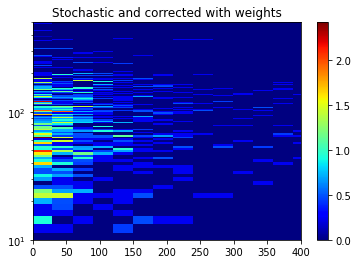

In [42]:
plt.hist2d(Stoch, Corrected , bins=(250, 250),weights = Weight, cmap=plt.cm.jet)
plt.colorbar()
plt.yscale('log')
plt.xlim(0,400)
plt.ylim(10,500)
plt.title('Stochastic and corrected with weights')

plt.show()

In [19]:
nfiles = 1
frame_arr = []; mctree = []
track_list = []
for i in range(nfiles):
    # This is your code, but I changed the file name creation
    with dataio.I3File(os.path.join(files_dir, file_list[i])) as infile:
        for frame in infile:
            if infile.stream.id != 'P': continue
            frame_arr.append(frame)
            mctree.append(frame['I3MCTree']) 
            
            
            
volume_radius = 500. 
volume_top    = 500.


counter_single = 0
counter_multi_reject = 0

def counters(volume_radius, volume_top, counter_single, counter_multi_reject):
    muon_index = np.zeros(len(frame_arr),dtype=int)
    for index, frame in enumerate(frame_arr):
        mmc_tracks = frame['MMCTrackList']
    
        if len(mmc_tracks) == 1:
            muon_index[index] = 0
            counter_single += 1
        else:
        # If more than one muon in the event, I need to find out their decay point
        # And whether they entered the detector
            muons_in_volume = 0
            for itrack, one_track in enumerate(mmc_tracks):
            # Check if the closest approach of the muon to the origin is within the detector radius
                if (np.sqrt(one_track.xc**2 + one_track.yc**2) < volume_radius) and (-volume_top<one_track.zc<volume_top):
                # If I land here, this muon could have entered my volume. Let's find out where it decayed
                    if one_track.particle.shift_along_track(one_track.particle.length).z < volume_top:
                    # This muon decayed under 500m, so it entered the volume.              
                        muons_in_volume += 1
                        muon_index[index] = itrack
        # After looping, check how many muons in volume I counted. If more than one, this is a bad event!
            if muons_in_volume > 1:
                muon_index[index] = -1
                counter_multi_reject += 1
    return counter_single, counter_multi_reject, muon_index

In [20]:
muon_index = counters(volume_radius, volume_top, counter_single, counter_multi_reject)[2] 

In [21]:

    


def func(frame,frame_arr, counter_single,counter_multi_reject,  volume_radius, volume_top, muon_index):
    
    corrected_charge = []
    distance = []
    charge = []
    times = []
    value = []
    mydom = []
    min_time_ar = []
    

    mctree = frame['I3MCTree']
    pulses = frame['SRTInIcePulsesDOMeff'].apply(frame)
    one_dom = pulses.items()
    

    
    gcd_file = '/cvmfs/icecube.opensciencegrid.org/data/GCD/GeoCalibDetectorStatus_IC86_Merged.i3.gz'
    gfile = dataio.I3File(gcd_file)
    gframe = gfile.pop_frame()
    geometry = gframe['I3Geometry']
        
    for i in range(len(one_dom)):
        Omkey= one_dom[i][0]
        and_time = one_dom[i][1]
        

        
    char = 0
    for pulse in one_dom[i][1]:
        time_pulse = 0
        time_pulse += pulse.time
        char += pulse.charge
            
        value.append(time_pulse)
        
    charge.append(char)
    times.append(time_pulse)

        
    for i in range(len(one_dom)):
        dom = geometry.omgeo[one_dom[i][0]]
    mydom.append(dom)
        

    mmctracks = frame['MMCTrackList']
    track = mmctracks[0].particle
    x_f = y_f = z_f = 0
    x_e = y_e = z_e = 0
    for i in range(len(mydom)):
        if times[i] == max(times):
            x_f = mydom[i].position.x
            y_f = mydom[i].position.y
            z_f = mydom[i].position.z
            
    for i in range(len(mydom)):
        if times[i] == min(times):
            x_e = mydom[i].position.x
            y_e = mydom[i].position.y
            z_e = mydom[i].position.z
   
    distance_between = np.sqrt((x_f - x_e)**2 + (y_f - y_e)**2 + (z_f - z_e)**2)
        
        
    for i in range(len(mydom)):
        d = phys_services.I3Calculator.cherenkov_distance(track, mydom[i].position)
    distance.append(d)
        
        
        
    corrected = 0
        
    for i in range(len(distance)):
        att_length = 50. 
        if distance[i] <= 200.0:corrected = charge[i]*distance[i]
    corrected_charge.append(corrected)
    
    corrected_charge = np.array(corrected_charge)
    distance = np.array(distance)
    times = np.array(times)
    value = np.array(value)

    return corrected_charge, distance_between
    

    


In [22]:
print(len(func(frame,frame_arr, counter_single,counter_multi_reject,volume_radius, volume_top, muon_index)[0]))

1


In [117]:
func(frame,frame_arr, counter_single,counter_multi_reject,volume_radius, volume_top, muon_index)[0]

array([118.6430705 , 248.64235443,  77.32922324, ..., 139.86582144,
       139.86582144, 139.86582144])

In [119]:
h= func(frame,frame_arr, counter_single,counter_multi_reject,volume_radius, volume_top, muon_index)[0]

Text(0, 0.5, 'Events')

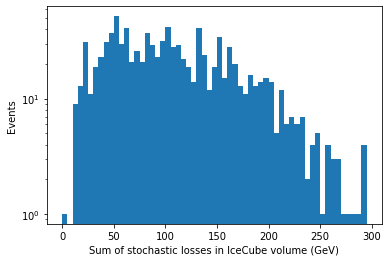

In [122]:
plt.hist(h, np.arange(0, 300, 5))
plt.yscale('log')
plt.xlabel('Sum of stochastic losses in IceCube volume (GeV)')
plt.ylabel('Events')

In [21]:
def corrected(single, multi,muon_index,volume_radius, volume_top):
    charge = []
    times = []
    min_time_ar = []
    mydom = []
    distance = []
 

    for i, frame in enumerate(frame_arr):
        
        if muon_index[i] >= 0 :continue            
            
        mmc_tr = frame['MMCTrackList'][int(muon_index[i])]
        mctree = frame['I3MCTree']
        pulses = frame['SRTInIcePulsesDOMeff'].apply(frame)
        one_dom = pulses.items()
        
    
    for i in range(len(one_dom)):
        Omkey= one_dom[i][0]
        and_time = one_dom[i][1]
        #print(Omkey,and_time)

        value = []
        char = 0
        for pulse in one_dom[i][1]:
            time_pulse = 0
            time_pulse += pulse.time
            value.append(time_pulse)
            times.append(time_pulse)
        
            char += pulse.charge
            if char > 0 :
                charge.append(char)
    

    min_time_ar.append(min(value))

 
    
    for i in range(len(value)-1):
        #print(times[len(times) - i - 1])
        if times[len(times) - i - 1] != min_time_ar: del times[len(times) - i - 1]
    #print(times)

   
     

    
   
    for i in range(len(one_dom)):
        dom = geometry.omgeo[one_dom[i][0]]    
        mydom.append(dom) 
        
    mmctracks = frame['MMCTrackList']
    track = mmctracks[0].particle
    
    x_f = y_f = z_f = 0
    x_e = y_e = z_e = 0
    for i in range(len(mydom)):
        if times[i] == max(times):
            x_f = mydom[i].position.x
            y_f = mydom[i].position.y
            z_f = mydom[i].position.z
            
    for i in range(len(mydom)):
        if times[i] == min(times):
            x_e = mydom[i].position.x
            y_e = mydom[i].position.y
            z_e = mydom[i].position.z
   
    dis = np.sqrt((x_f - x_e)**2 + (y_f - y_e)**2 + (z_f - z_e)**2)
    
    
    for i in range(len(mydom)):
        d = phys_services.I3Calculator.cherenkov_distance(track, mydom[i].position)
        distance.append(d)
    #print(len(distance))
    #print(len(charge))
    
    corrected_charge = []
    for i in range(len(distance)):
        att_length = 50. 
        if distance[i] <= 200.0:
            corrected = charge[i]*distance[i]
            corrected_charge.append(corrected)
        
    
    return corrected_charge, dis, times, one_dom   


In [24]:
print(corrected(single, multi,volume_radius, volume_top)[0])

UnboundLocalError: local variable 'frame' referenced before assignment

In [23]:
def corrected(single, multi,  volume_radius, volume_top):
    pulses = frame['SRTInIcePulsesDOMeff'].apply(frame)
    one_dom = pulses.items()
    
    muon_index = np.zeros(len(frame_arr),dtype=int)
    charge = []
    times = []
    min_time_ar = []
    mydom = []
    distance = []
    



    for i, frame in enumerate(frame_arr):
        if muon_index[i] < 0:
            continue   
    
    for i in range(len(one_dom)):
        Omkey= one_dom[i][0]
        and_time = one_dom[i][1]
        #print(Omkey,and_time)

        value = []
        char = 0
        for pulse in one_dom[i][1]:
            time_pulse = 0
            time_pulse += pulse.time
            value.append(time_pulse)
            times.append(time_pulse)
        
            char += pulse.charge
            if char > 0 :
                charge.append(char)
    

    min_time_ar.append(min(value))

 
    
    for i in range(len(value)-1):
        #print(times[len(times) - i - 1])
        if times[len(times) - i - 1] != min_time_ar: del times[len(times) - i - 1]
    #print(times)

   
     
    
    gcd_file = '/cvmfs/icecube.opensciencegrid.org/data/GCD/GeoCalibDetectorStatus_IC86_Merged.i3.gz'
    gfile = dataio.I3File(gcd_file)
    gframe = gfile.pop_frame()
    geometry = gframe['I3Geometry']
    
   
    for i in range(len(one_dom)):
        dom = geometry.omgeo[one_dom[i][0]]    
        mydom.append(dom) 
        
    mmctracks = frame['MMCTrackList']
    track = mmctracks[0].particle
    
    x_f = y_f = z_f = 0
    x_e = y_e = z_e = 0
    for i in range(len(mydom)):
        if times[i] == max(times):
            x_f = mydom[i].position.x
            y_f = mydom[i].position.y
            z_f = mydom[i].position.z
            
    for i in range(len(mydom)):
        if times[i] == min(times):
            x_e = mydom[i].position.x
            y_e = mydom[i].position.y
            z_e = mydom[i].position.z
   
    dis = np.sqrt((x_f - x_e)**2 + (y_f - y_e)**2 + (z_f - z_e)**2)
    
    
    for i in range(len(mydom)):
        d = phys_services.I3Calculator.cherenkov_distance(track, mydom[i].position)
        distance.append(d)
    #print(len(distance))
    #print(len(charge))
    
    corrected_charge = []
    for i in range(len(distance)):
        att_length = 50. 
        if distance[i] <= 200.0:
            corrected = charge[i]*distance[i]
            corrected_charge.append(corrected)
        
    
    return corrected_charge, dis, times, one_dom